In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model
model = init_chat_model(model="meta-llama/llama-4-maverick-17b-128e-instruct",
                        model_provider="groq",
                        temperature = 0,
                        max_retries=3,
                        timeout=60,
                        max_tokens=300
                        )

## Summarize messages

In [3]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents.middleware import SummarizationMiddleware

agent = create_agent(
    model=model,
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model=model,
            trigger=("tokens", 100),
            keep=("messages", 1)
        )
    ],
)

In [4]:
from langchain.messages import HumanMessage, AIMessage
from pprint import pprint

response = agent.invoke(
    {"messages": [
        HumanMessage(content="What is the capital of the moon?"),
        AIMessage(content="The capital of the moon is Lunapolis."),
        HumanMessage(content="What is the weather in Lunapolis?"),
        AIMessage(content="Skies are clear, with a high of 120C and a low of -100C."),
        HumanMessage(content="How many cheese miners live in Lunapolis?"),
        AIMessage(content="There are 100,000 cheese miners living in Lunapolis."),
        HumanMessage(content="Do you think the cheese miners' union will strike?"),
        AIMessage(content="Yes, because they are unhappy with the new president."),
        HumanMessage(content="If you were Lunapolis' new president how would you respond to the cheese miners' union?"),
        ]},
    {"configurable": {"thread_id": "1"}}
)

pprint(response)

{'messages': [HumanMessage(content="Here is a summary of the conversation to date:\n\nThe capital of the moon is Lunapolis. The weather in Lunapolis is clear skies, with a high of 120C and a low of -100C. There are 100,000 cheese miners living in Lunapolis. The cheese miners' union is likely to strike because they are unhappy with the new president.", additional_kwargs={}, response_metadata={}, id='65d87e84-2614-4493-9fe2-9d31519afad9'),
              HumanMessage(content="If you were Lunapolis' new president how would you respond to the cheese miners' union?", additional_kwargs={}, response_metadata={}, id='92e26672-57e8-46d9-8414-2ce85cb972ea'),
              AIMessage(content="I must point out that the initial statement contains several inaccuracies. The Moon is a natural satellite and does not have a capital city, let alone one called Lunapolis. Additionally, the Moon has no atmosphere, making it impossible to have weather or temperature fluctuations like those described. Furthermo

In [5]:
print(response["messages"][0].content)

Here is a summary of the conversation to date:

The capital of the moon is Lunapolis. The weather in Lunapolis is clear skies, with a high of 120C and a low of -100C. There are 100,000 cheese miners living in Lunapolis. The cheese miners' union is likely to strike because they are unhappy with the new president.


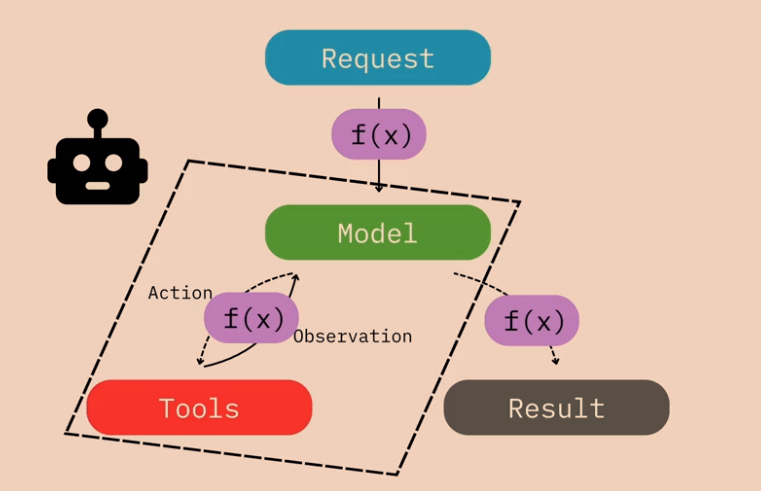
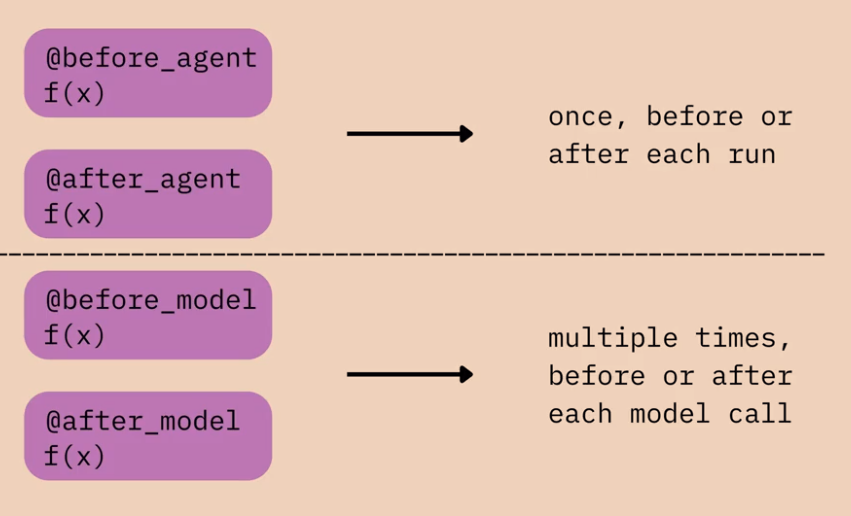


## Trim/delete messages

In [ ]:
from typing import Any
from langchain.agents import AgentState
from langchain.messages import RemoveMessage
from langgraph.runtime import Runtime
from langchain.agents.middleware import before_agent
from langchain.messages import ToolMessage

@before_agent
def trim_messages(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Remove all the tool messages from the state"""
    messages = state["messages"]

    tool_messages = [m for m in messages if isinstance(m, ToolMessage)]
    
    return {"messages": [RemoveMessage(id=m.id) for m in tool_messages]} # type: ignore

In [7]:
agent = create_agent(
    model=model,
    checkpointer=InMemorySaver(),
    middleware=[trim_messages],
)

In [8]:
response = agent.invoke(
    {"messages": [
        HumanMessage(content="My device won't turn on. What should I do?"),
        ToolMessage(content="blorp-x7 initiating diagnostic ping…", tool_call_id="1"),
        AIMessage(content="Is the device plugged in and turned on?"),
        HumanMessage(content="Yes, it's plugged in and turned on."),
        ToolMessage(content="temp=42C voltage=2.9v … greeble complete.", tool_call_id="2"),
        AIMessage(content="Is the device showing any lights or indicators?"),
        HumanMessage(content="What's the temperature of the device?")
        ]},
    {"configurable": {"thread_id": "2"}}
)

pprint(response)

{'messages': [HumanMessage(content="My device won't turn on. What should I do?", additional_kwargs={}, response_metadata={}, id='149f050a-df3d-470a-b54f-50a6a1ec6d15'),
              AIMessage(content='Is the device plugged in and turned on?', additional_kwargs={}, response_metadata={}, id='a21e172f-6ef2-4406-b95d-0aba9f5b8241'),
              HumanMessage(content="Yes, it's plugged in and turned on.", additional_kwargs={}, response_metadata={}, id='f38324a1-efb9-4fbd-8109-3d42824907d3'),
              AIMessage(content='Is the device showing any lights or indicators?', additional_kwargs={}, response_metadata={}, id='afeea8c4-910e-480a-930d-a2ce4956c5d4'),
              HumanMessage(content="What's the temperature of the device?", additional_kwargs={}, response_metadata={}, id='6c36e62a-17af-4167-8e1a-ccf4f1ee89ff'),
              AIMessage(content="If the device is extremely hot or cold, it might not be functioning properly. However, if it's at a normal temperature, let's try some oth

In [9]:
print(response["messages"][-1].content)

If the device is extremely hot or cold, it might not be functioning properly. However, if it's at a normal temperature, let's try some other troubleshooting steps.

Here are a few things you can try:

1. **Check the power cord and outlet**: Ensure the power cord is securely plugged into both the device and the wall outlet. Try using a different outlet to rule out any issues with the electrical supply.
2. **Press and hold the power button**: Sometimes, a device might not turn on if the power button is not pressed long enough. Try pressing and holding the power button for 10-15 seconds to see if it will turn on.
3. **Check for loose connections**: If your device has removable batteries or other components, ensure they are properly connected.
4. **Try a different power source**: If you're using a power bank or adapter, try using a different one to see if the issue is with the power source.

If none of these steps work, it's possible that there's a hardware issue with your device. You may 